In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

In [2]:
#autoreload 
from attribution import Attribution

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 365})
    },
    'hm': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 30, 'k': 365})
    },
    'nfi': {
        'spatial': ('weighting_function', {'x0': 600, 'k': 1500}),
        'temporal': ('weighting_function', {'x0': 365, 'k': 2.5 * 365})
    },
    'senfseidl': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 180, 'k': 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 1000}),
        'temporal': ('weighting_function', {'x0': 1, 'k': 90})
    },
    'cdi': {
        'spatial': ('weighting_function', {'x0': 5000, 'k': 5000}),
        'temporal': ('weighting_function', {'x0': 10, 'k': 90})
    },
    'forms': {
        'spatial': ('weighting_function', {'x0': 30, 'k': 100}),
        'temporal': ('weighting_function', {'x0': 90, 'k': 180})
    }
}


ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('exponential_decay', {'x0': 0, 'k': 0.0025})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 100}),
        'temporal': ('exponential_decay', {'x0': 0, 'k': 0.005})
    },
    'anthropogenic': {
        'spatial': ('step', {'start': 0, 'end': 250}),
        'temporal': ('step', {'start': 0, 'end': 365})
    }
}

# dspatial_f = {'dfde': (3000, 0), 'hm': (1000, 0), 'nfi': (3000, 600), 'senfseidl': (500, 0), 'bdiff': (500, 0), 'cdi':(3000, 0), 'forms':(500, 0)}
# dtemporal_f = {'dfde': (365, 0), 'hm': (180, 0), 'nfi': (2.5 * 365, 0), 'senfseidl': (180, 0), 'bdiff': (180, 0), 'cdi':(180, 0), 'forms':(180, 0)} 

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': 1., 'bdiff': 1.0, 'cdi':.5, 'forms':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

from constants import DCLASS_SCORE

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=7, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 451.88 km2, median : 25.00 km2


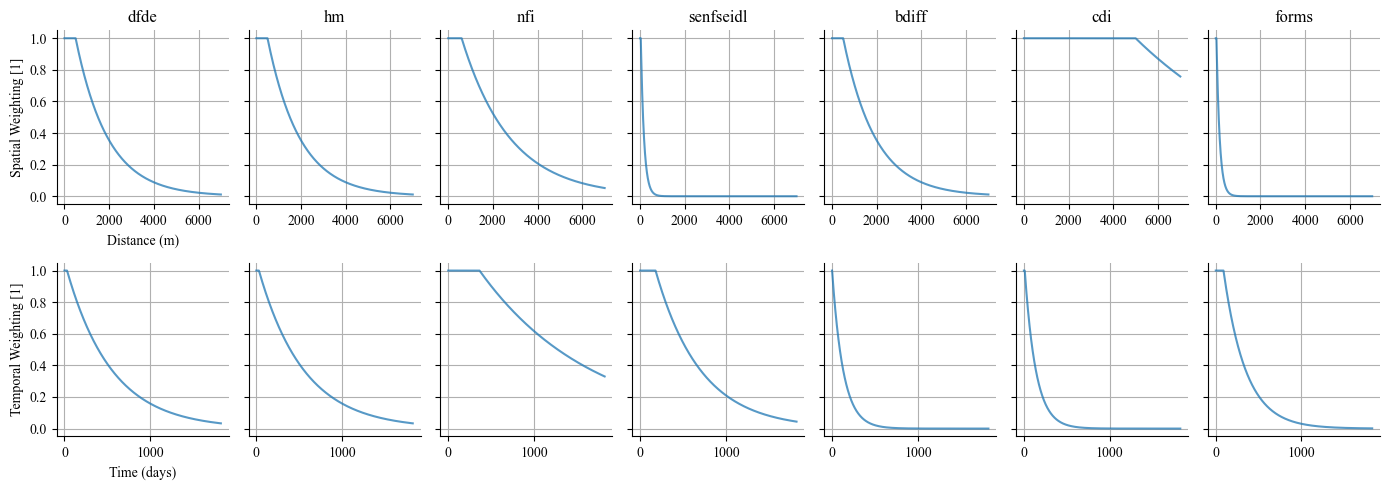

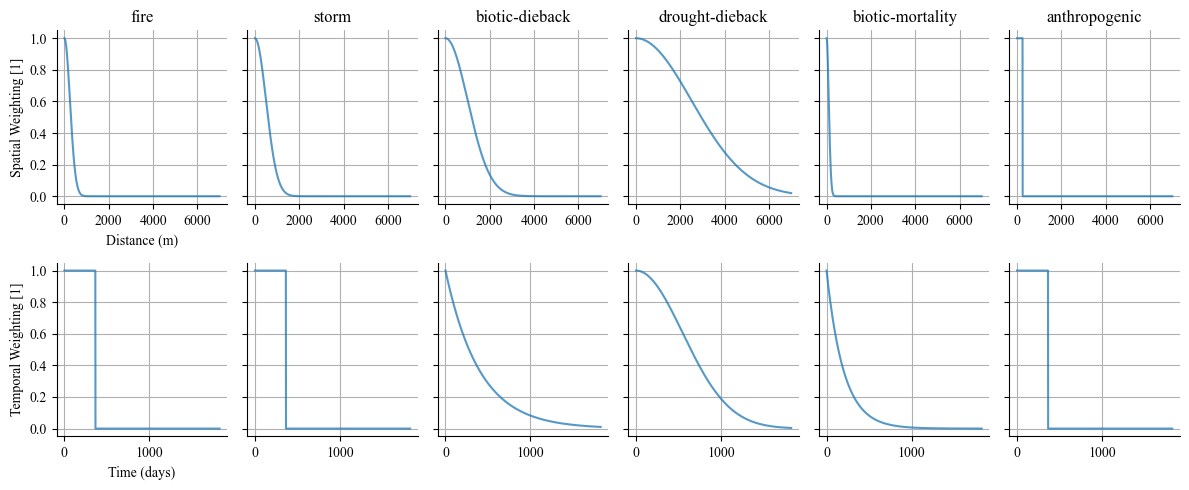

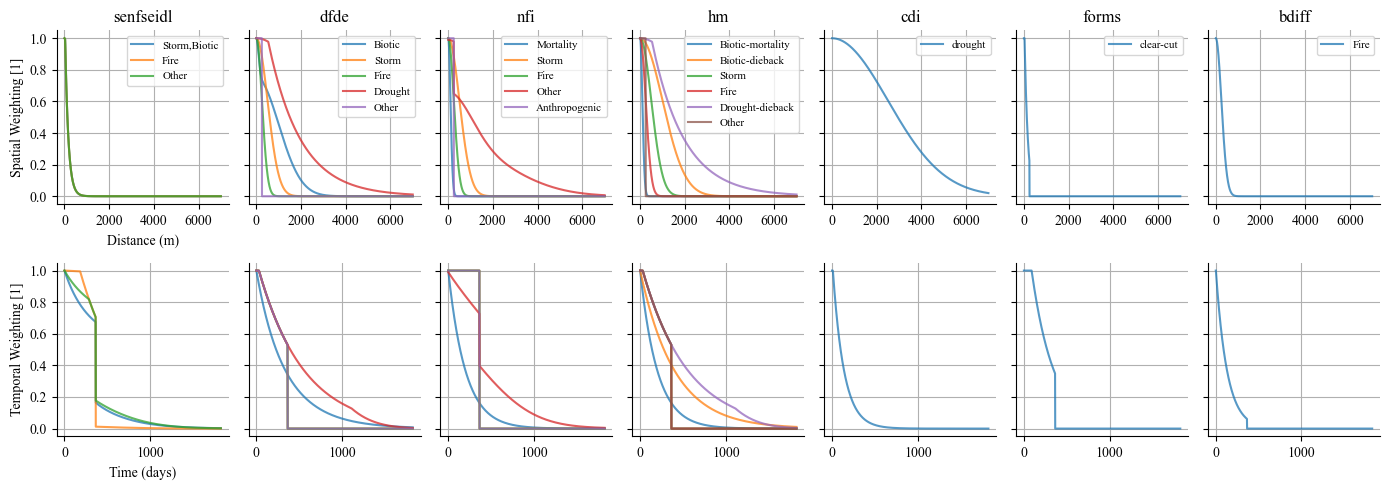

In [3]:
attribution.plot_weighting_functions()

In [4]:
attribution.final_weighting_dict

{'senfseidl': {'Storm,Biotic': {'spatial': <function utils.get_combined_weighting.<locals>.<lambda>(x)>,
   'temporal': <function utils.get_combined_weighting.<locals>.<lambda>(x)>},
  'Fire': {'spatial': <function utils.get_combined_weighting.<locals>.<lambda>(x)>,
   'temporal': <function utils.get_combined_weighting.<locals>.<lambda>(x)>},
  'Other': {'spatial': <function utils.get_combined_weighting.<locals>.<lambda>(x)>,
   'temporal': <function utils.get_combined_weighting.<locals>.<lambda>(x)>}},
 'dfde': {'Biotic': {'spatial': <function utils.get_combined_weighting.<locals>.<lambda>(x)>,
   'temporal': <function utils.get_combined_weighting.<locals>.<lambda>(x)>},
  'Storm': {'spatial': <function utils.get_combined_weighting.<locals>.<lambda>(x)>,
   'temporal': <function utils.get_combined_weighting.<locals>.<lambda>(x)>},
  'Fire': {'spatial': <function utils.get_combined_weighting.<locals>.<lambda>(x)>,
   'temporal': <function utils.get_combined_weighting.<locals>.<lambda>(

In [4]:
pd.options.mode.chained_assignment = None
import time 

from utils import compute_tree_coherence, compute_class_similarity
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': dclass_score}, 1.0)}

for year in range(2015, 2021):
    print(f'year : {year}')
    attribution.get_clusters(year, dcustom_similiraity_function=dcustom_similarity_function, dir_=f'../data/results/cluster_{year}')
    time.sleep(180)

year : 2015
number of groups : 57627, estimated time (4 cores) = 28.813499999999998 min


100%|██████████| 6/6 [16:46<00:00, 167.80s/it]


year : 2016
number of groups : 101180, estimated time (4 cores) = 50.59 min


100%|██████████| 11/11 [37:46<00:00, 206.02s/it]


year : 2017
number of groups : 118262, estimated time (4 cores) = 59.131 min


100%|██████████| 12/12 [40:01<00:00, 200.10s/it]


year : 2018
number of groups : 94214, estimated time (4 cores) = 47.107 min


100%|██████████| 10/10 [37:50<00:00, 227.03s/it]


year : 2019
number of groups : 98009, estimated time (4 cores) = 49.0045 min


100%|██████████| 10/10 [38:07<00:00, 228.73s/it]


year : 2020
number of groups : 102713, estimated time (4 cores) = 51.3565 min


100%|██████████| 11/11 [40:31<00:00, 221.08s/it]


# test v0.2

In [4]:
pd.options.mode.chained_assignment = None
import time 

from utils import compute_tree_coherence, compute_class_similarity
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': DCLASS_SCORE}, 1.0)}

year = 2018 
# attribution.get_clusters(year, dcustom_similiraity_function=dcustom_similarity_function, dir_=f'../data/results/cluster_{year}')
attribution_year = attribution.get_temporal_spatial_join(year, dir_=f'../data/results/cluster_{year}')
 

In [5]:
attribution_year['dataset'].value_counts()

dataset
cdi          554211
senfseidl    208927
reference    114896
bdiff         84211
forms         25839
hm            16609
nfi            1296
dfde            318
Name: count, dtype: int64[pyarrow]

In [7]:
attribution.get_clusters(year, dcustom_similiraity_function=dcustom_similarity_function, dir_=f'../data/results/cluster_{year}')

number of groups : 114896, estimated time (4 cores) = 57.44799999999999 min


100%|██████████| 12/12 [1:24:56<00:00, 424.68s/it]


True